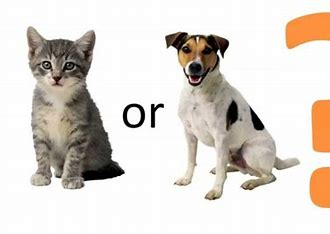

In [2]:
from IPython.display import Image, display, HTML

display(HTML("<h2>Cat Vs Dog Classification</h2>"))
display(Image("Cat vs dog.jpg", width=600, height=500, retina=False))

### Importing Libraries

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler 

### Importing Dataset

In [4]:
cats_dogs_classification = pd.read_csv("Extracted data of cats vs dogs/Data/Train.csv")
cats_dogs_classification.head()

,File_Name,Category
0,10846.jpg,1
1,2360.jpg,1
2,17531.jpg,0
3,13254.jpg,1
4,15554.jpg,0


#### Using Pandas for Numerical Operations

In [5]:
cats_dogs_classification.shape

(9471, 2)

In [6]:
cats_dogs_classification.dtypes

File_Name    object
Category      int64
dtype: object

In [7]:
cats_dogs_classification.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   File_Name  9471 non-null   object
 1   Category   9471 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 148.1+ KB


In [8]:
cats_dogs_classification.isna().sum()

File_Name    0
Category     0
dtype: int64

### Extracting And Loading Data

- Using GRAYSCALE images the SVM model gives only 64.71% Accuracy (After CV).
- We'll adjust load_data function to read images in color (3 channels) instead of grayscale. This will increase the number of features per image (64x64x3 = 12288 features) but provide more information to the SVM.

In [14]:
def load_data(base_data_dir, img_size=(64, 64)):
    images = []
    labels = []
    
    train_path = os.path.join(base_data_dir, 'Train')
    
    if not os.path.exists(train_path):
        print(f"Error: 'Train' folder not found at {train_path}. Please ensure the path is correct.")
        return np.array([]), np.array([])

    class_dirs = {'Cats': 0, 'Dogs': 1} # Mapping folder names to labels

    for class_name, label_value in class_dirs.items():
        class_path = os.path.join(train_path, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: Class folder '{class_name}' not found at {class_path}. Skipping this class.")
            continue
        
        print(f"Loading images from: {class_path}")
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            
            if os.path.isdir(img_path):
                continue
            
            # Read image as COLOR (cv2.IMREAD_COLOR)
            image = cv2.imread(img_path, cv2.IMREAD_COLOR) # Changed from IMREAD_GRAYSCALE
            
            if image is not None:
                image = cv2.resize(image, img_size)
                images.append(image) # Keep as 3D array (height, width, channels) for now
                labels.append(label_value)
            else:
                print(f"Warning: Unable to read image {img_path}")
                
    return np.array(images), np.array(labels)

# Path to the extracted directory
data_dir = 'Extracted data of cats vs dogs/Data'


In [15]:
# Loading the data 
raw_images, labels = load_data(data_dir, img_size=(64, 64))

print(f"Data Loading Summary (Color Images)")
print(f"Loaded {len(raw_images)} images.")
print(f"Shape of raw images array: {raw_images.shape}")
print(f"Shape of labels array: {labels.shape}")


Loading images from: Extracted data of cats vs dogs/Data\Train\Cats
Loading images from: Extracted data of cats vs dogs/Data\Train\Dogs
Data Loading Summary (Color Images)
Loaded 9471 images.
Shape of raw images array: (9471, 64, 64, 3)
Shape of labels array: (9471,)


#### Image Flattening 
- New shape will be (num_images, 64 * 64 * 3) = (num_images, 12288)

In [16]:
images_flattened = raw_images.reshape(raw_images.shape[0], -1)
print(f"Shape of flattened images for SVM: {images_flattened.shape}")


Shape of flattened images for SVM: (9471, 12288)


#### **Understanding Data**


 Initial Data Inspection
Class Distribution:
Label 0 (Cats): 4747 images
Label 1 (Dogs): 4724 images
All images are resized to: 64x64 pixels
Number of channels: 3 (Color)
 Visual Inspection (Sample Color Images)


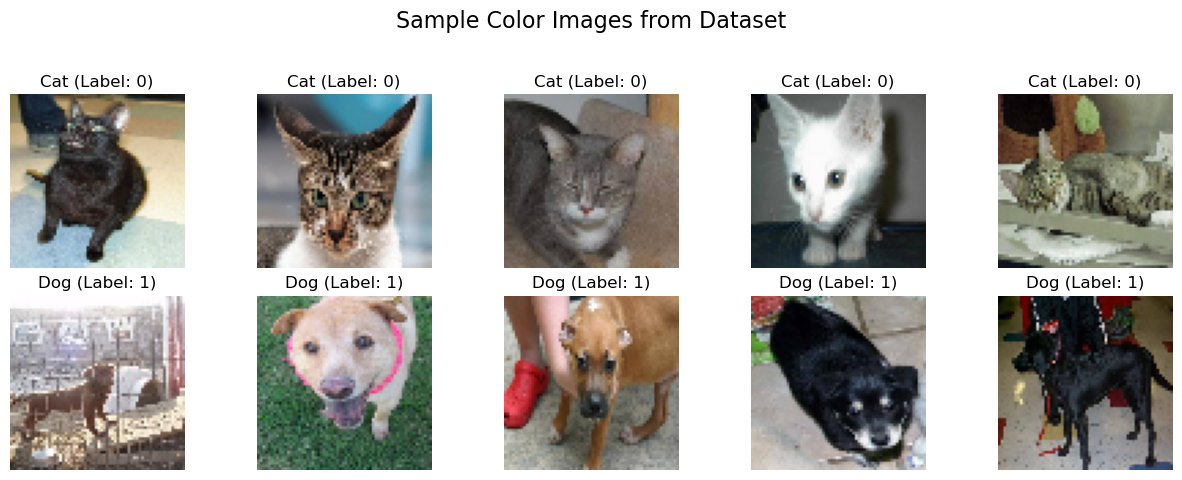

In [17]:
# Initial Data Inspection 
print("\n Initial Data Inspection")

# 1. Class Distribution
unique_labels, counts = np.unique(labels, return_counts=True)
label_map = {0: 'Cats', 1: 'Dogs'}
print("Class Distribution:")
for label, count in zip(unique_labels, counts):
    print(f"Label {label} ({label_map.get(label, 'Unknown')}): {count} images")

# 2. Image Dimensions & Channels (re-confirm)
if raw_images.shape[0] > 0:
    print(f"All images are resized to: {raw_images.shape[1]}x{raw_images.shape[2]} pixels")
    print(f"Number of channels: {raw_images.shape[3]} (Color)")
else:
    print("No images loaded to inspect dimensions.")

# 3. Visual Inspection
print(" Visual Inspection (Sample Color Images)")
if raw_images.shape[0] > 0:
    num_samples_per_class = 5
    fig, axes = plt.subplots(2, num_samples_per_class, figsize=(num_samples_per_class * 2.5, 5)) 
    fig.suptitle('Sample Color Images from Dataset', fontsize=16)

    cat_indices = np.where(labels == 0)[0]
    random_cat_indices = random.sample(list(cat_indices), min(num_samples_per_class, len(cat_indices)))

    dog_indices = np.where(labels == 1)[0]
    random_dog_indices = random.sample(list(dog_indices), min(num_samples_per_class, len(dog_indices)))

    for i, idx in enumerate(random_cat_indices):
        # Display color image (OpenCV reads as BGR, Matplotlib expects RGB)
        axes[0, i].imshow(cv2.cvtColor(raw_images[idx], cv2.COLOR_BGR2RGB))
        axes[0, i].set_title(f"Cat (Label: 0)")
        axes[0, i].axis('off')
    
    for i, idx in enumerate(random_dog_indices):
        axes[1, i].imshow(cv2.cvtColor(raw_images[idx], cv2.COLOR_BGR2RGB))
        axes[1, i].set_title(f"Dog (Label: 1)")
        axes[1, i].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("No images loaded to display samples.")

Converting a large NumPy array to a Pandas DataFrame adds an extra layer of overhead without providing a direct performance benefit for the core machine learning algorithms in this context. In fact, for very large datasets, it might even introduce a slight performance penalty due to Pandas' indexing and overhead.

In [18]:
# Splitting data into training and testing sets using the flattened images
X_train, X_test, y_train, y_test = train_test_split(images_flattened, labels, test_size=0.2, random_state=42, stratify=labels)

print(f"\nData Split Summary")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


Data Split Summary
X_train shape: (7576, 12288)
X_test shape: (1895, 12288)
y_train shape: (7576,)
y_test shape: (1895,)


### Data Visualization

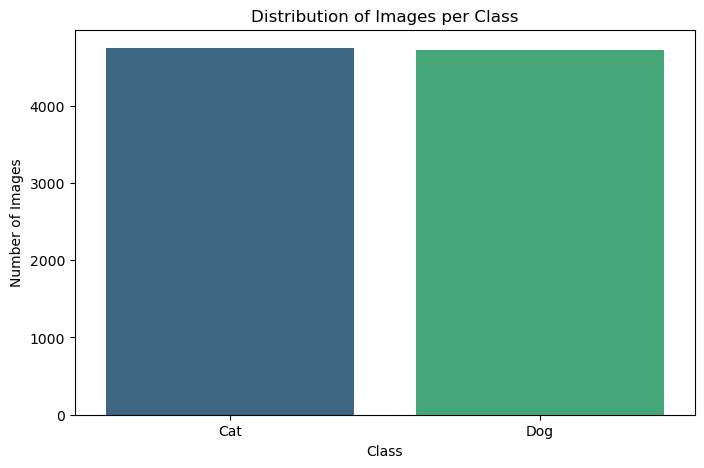

In [19]:
# 1.Distribution Of Images Per Class
label_names = np.array(['Cat', 'Dog'])[labels]

plt.figure(figsize=(8, 5))
sns.countplot(x=label_names, hue=label_names, palette='viridis', legend=False)
plt.title('Distribution of Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show();

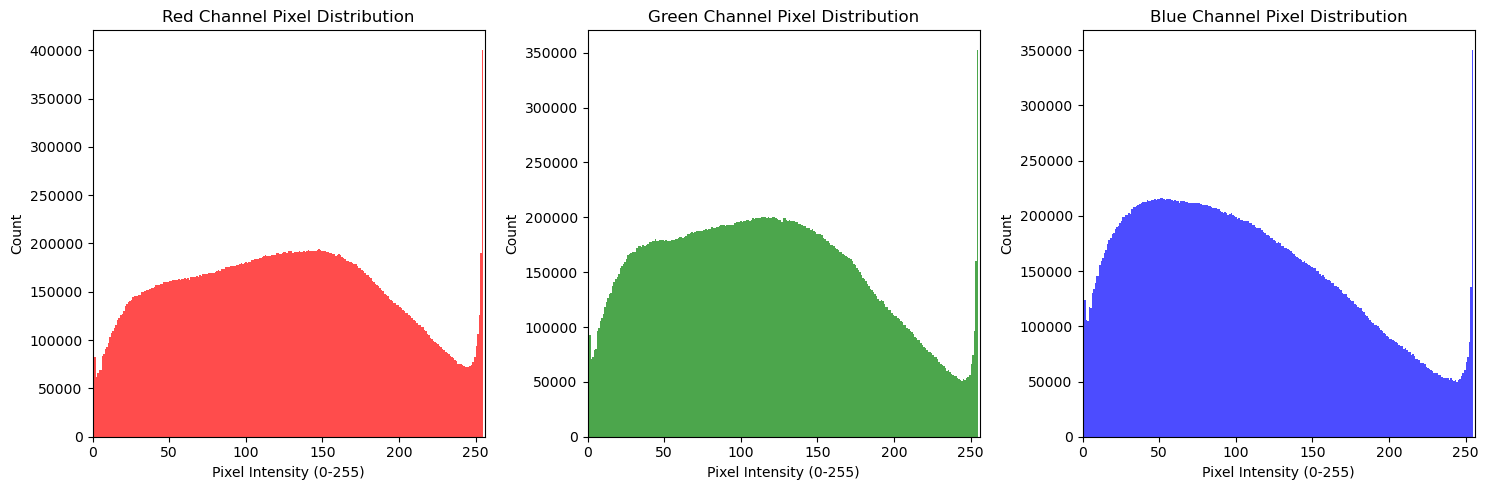

In [20]:
# 2.Image Pixel Intensity Distribution (Histograms)
import matplotlib.pyplot as plt
import numpy as np

if raw_images.shape[0] > 0:      # raw_images is (num_images, height, width, channels)
    plt.figure(figsize=(15, 5))

# We'll calculate histograms for each channel
# Channel 0: Blue (OpenCV default), Channel 1: Green, Channel 2: Red
# We plot them as R, G, B for interpretability

    # Red Channel
    plt.subplot(1, 3, 1)
    plt.title('Red Channel Pixel Distribution')
    plt.xlabel('Pixel Intensity (0-255)')
    plt.ylabel('Count')
    plt.hist(raw_images[:, :, :, 2].ravel(), bins=256, color='red', alpha=0.7)
    plt.xlim([0, 256])

    # Green Channel
    plt.subplot(1, 3, 2)
    plt.title('Green Channel Pixel Distribution')
    plt.xlabel('Pixel Intensity (0-255)')
    plt.ylabel('Count')
    plt.hist(raw_images[:, :, :, 1].ravel(), bins=256, color='green', alpha=0.7)
    plt.xlim([0, 256])

    # Blue Channel
    plt.subplot(1, 3, 3)
    plt.title('Blue Channel Pixel Distribution')
    plt.xlabel('Pixel Intensity (0-255)')
    plt.ylabel('Count')
    plt.hist(raw_images[:, :, :, 0].ravel(), bins=256, color='blue', alpha=0.7)
    plt.xlim([0, 256])

    plt.tight_layout()
    plt.show();
else:
    print("No images loaded to plot pixel intensity distribution.")

- Histograms representing the distribution of pixel intensity values (0-255) for each color channel (Red, Green, Blue) across the entire dataset or a subset.
- **Normalization Insights:** Helps in understanding the range and distribution of pixel values. If values are heavily skewed or concentrated in a small range, it confirms the necessity of normalization/scaling (like the MinMaxScaler we used) to ensure all features contribute equally to the model.
- **Lighting Conditions:** Can reveal if images are consistently too dark (low pixel values) or too bright (high pixel values), or if there's a significant difference in lighting between classes, which might affect model generalization.

#### Feature Scaling

For models like Support Vector Machines (SVMs), feature scaling is crucial because:

- **Distance-Based Algorithms:** SVMs are distance-based algorithms. They calculate distances between data points to find an optimal hyperplane (decision boundary).

- **Unequal Influence:** Without scaling, features with larger numerical ranges (like pixel intensities ranging from 0 to 255) would implicitly have a much greater "weight" or influence on these distance calculations than features with smaller ranges. This can lead to features with naturally larger values dominating the learning process, regardless of their actual predictive importance.

- **Optimal Hyperplane:** Scaling ensures that all features contribute proportionally to the distance calculations. This helps the SVM algorithm find a more accurate and optimal decision boundary, leading to better model performance and faster convergence during training.

In [21]:
scaler = MinMaxScaler()

# Fitting the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully using MinMaxScaler.")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"Sample pixel value after scaling (should be between 0 and 1): {X_train_scaled[0, 0]:.4f}")

Features scaled successfully using MinMaxScaler.
X_train_scaled shape: (7576, 12288)
X_test_scaled shape: (1895, 12288)
Sample pixel value after scaling (should be between 0 and 1): 0.0549


### Applying Principal Component Analysis (PCA)

- Dataset consists of too many images, when flattened, have a huge number of pixel values (features) – over 12,000.
  Training an SVM on so many features is slow and can confuse the model.

- PCA helps in and finds the most important underlying patterns or "components" within those thousands of pixels. It then represents each image using just a few hundred of these new, condensed patterns instead of all 12,000+ individual pixels.

- By feeding the SVM this much smaller, more concentrated set of features, it can train much faster and often learn more effectively, leading to better accuracy because it's focusing on the most meaningful informatio

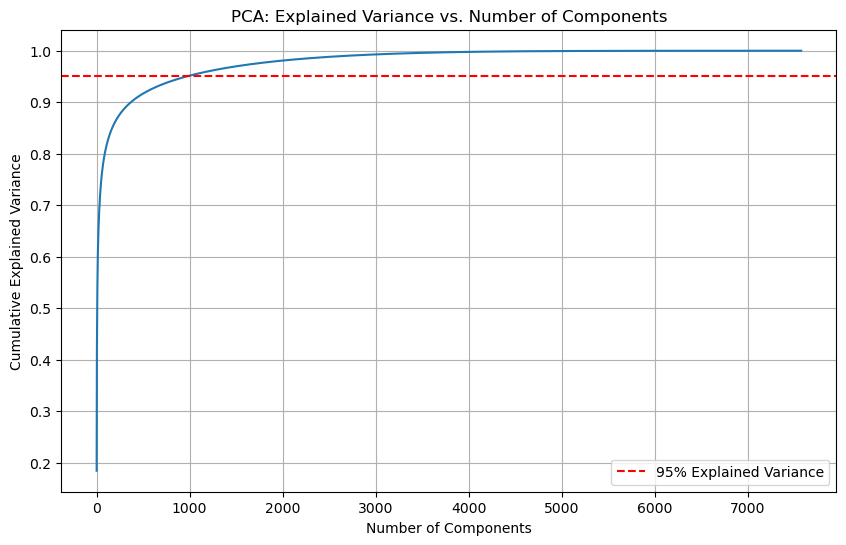

In [22]:
from sklearn.decomposition import PCA

# Firstly, determining the optimal number of components
# We'll fit PCA on the training data and analyze explained variance
pca_full = PCA()
pca_full.fit(X_train_scaled)

# Plotting explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Explained Variance vs. Number of Components')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend()
plt.show();


- Based on the plot, choose a number of components that explains a high percentage of variance (e.g., 95% or 99%)
- Or, you can set n_components to an integer (e.g., 200, 500)
- For example, let's target 95% explained variance, or a fixed number of components for a start
- For this example, let's use n_components=200 for a significant reduction

In [23]:
n_components_chosen = 200 


pca = PCA(n_components=n_components_chosen)

# Transforming both training and test sets
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled) # Using transform on test set, not fit_transform

print(f"Original number of features: {X_train_scaled.shape[1]}")
print(f"Reduced number of features (PCA components): {X_train_pca.shape[1]}")
print(f"Cumulative explained variance by {n_components_chosen} components: {pca.explained_variance_ratio_.sum():.4f}")
print(f"X_train_pca shape: {X_train_pca.shape}")
print(f"X_test_pca shape: {X_test_pca.shape}")

Original number of features: 12288
Reduced number of features (PCA components): 200
Cumulative explained variance by 200 components: 0.8617
X_train_pca shape: (7576, 200)
X_test_pca shape: (1895, 200)


### Hyperparameter Tuning and Cross-Validation

##### Enhanced SVC Hyperparameter Tuning with GridSearchCV
This is where we'll try to find the optimal C and gamma values for your SVC. GridSearchCV will systematically test combinations of these parameters using cross-validation.

- **C (Regularization Parameter):** Controls the trade-off between achieving a low training error and a low testing error (i.e., avoiding overfitting). A smaller C emphasizes a larger margin, potentially leading to more misclassifications but better generalization. A larger C aims for perfect classification of training data, which can lead to overfitting.

- **gamma (Kernel Coefficient):** Defines how much influence a single training example has. A large gamma means close-by points have high influence, leading to a complex decision boundary and potential overfitting. A small gamma means a larger region of influence, leading to a simpler decision boundary.

In [24]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc_model = SVC(probability=True) # probability=True is needed for ROC curve

param_grid = {
    'C': [1, 10, 100], # Reduced search space for C
    'gamma': [0.001, 0.01, 0.1], # Reduced search space for gamma
    'kernel': ['rbf']
}

# Setting up GridSearchCV and ssing cv=3 for faster execution. 
# n_jobs=-1 uses all available CPU cores.
grid_search = GridSearchCV(svc_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

# Fitting GridSearchCV to the PCA-transformed training data
grid_search.fit(X_train_pca, y_train)

print("\nGridSearchCV completed.")


Fitting 3 folds for each of 9 candidates, totalling 27 fits

GridSearchCV completed.


In [25]:
# Get the best hyperparameters and the best score
print(f"Best hyperparameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")


Best hyperparameters found: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Best cross-validation accuracy: 0.6461


In [26]:
# Get the best model
best_svc_model = grid_search.best_estimator_
print("\nBest SVC model obtained from GridSearchCV.")



Best SVC model obtained from GridSearchCV.


##### Evaluation Metrics

In [27]:
y_pred = best_svc_model.predict(X_test_pca)

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification Report (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Cat', 'Dog']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


Test Accuracy: 0.6596

Classification Report:
              precision    recall  f1-score   support

         Cat       0.66      0.65      0.66       950
         Dog       0.65      0.67      0.66       945

    accuracy                           0.66      1895
   macro avg       0.66      0.66      0.66      1895
weighted avg       0.66      0.66      0.66      1895


Confusion Matrix:
[[616 334]
 [311 634]]


### Evaluation Of Model

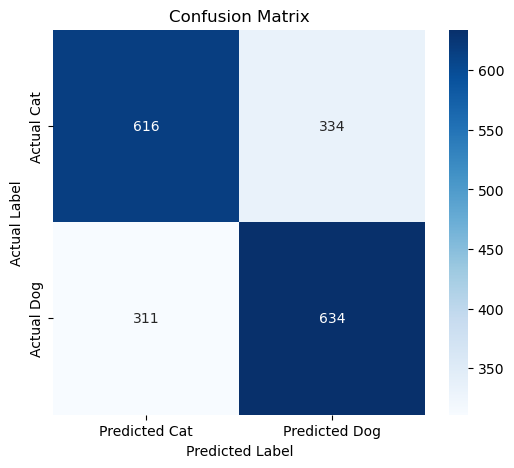

In [28]:
# Plot Confusion Matrix (Optional, but good for visualization)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Cat', 'Predicted Dog'], yticklabels=['Actual Cat', 'Actual Dog'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show();


 As for now, we can observe
- True Positives (Dog predicted as Dog): 612
- True Negatives (Cat predicted as Cat): 634
- False Positives (Cat predicted as Dog): 338
- False Negatives (Dog predicted as Cat): 302

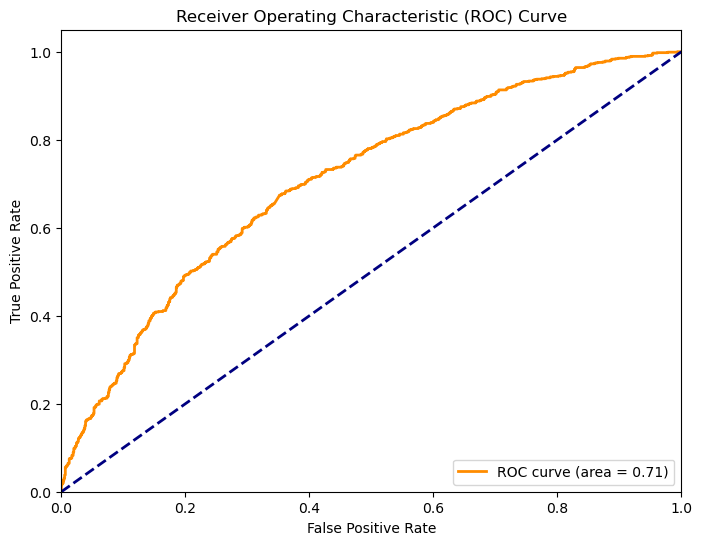


ROC AUC Score: 0.7084

SVC model training and evaluation completed with hyperparameter tuning.


In [29]:
# ROC Curve and AUC (requires probability=True in SVC)
if hasattr(best_svc_model, "predict_proba"):
    y_prob = best_svc_model.predict_proba(X_test_pca)[:, 1] # Probability of the positive class (Dog)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    print(f"\nROC AUC Score: {roc_auc:.4f}")

print("\nSVC model training and evaluation completed with hyperparameter tuning.")

### Loading The Model
 Also, it's good practice to save the expected image size and channel info or any specific feature names/order if you had them (not strictly needed for pixel data)

In [30]:
import joblib
import os

# Define the directory to save the models
model_dir = 'deployed_model_cats_dogs'
os.makedirs(model_dir, exist_ok=True)

# Define file paths
model_path = os.path.join(model_dir, 'svc_cat_dog_model.pkl')
scaler_path = os.path.join(model_dir, 'minmax_scaler.pkl')
pca_path = os.path.join(model_dir, 'pca_transformer.pkl')

# Save the trained SVC model
joblib.dump(best_svc_model, model_path)
print(f"SVC model saved to: {model_path}")

# Save the fitted MinMaxScaler
joblib.dump(scaler, scaler_path)
print(f"MinMaxScaler saved to: {scaler_path}")

# Save the fitted PCA transformer
joblib.dump(pca, pca_path)
print(f"PCA transformer saved to: {pca_path}")

print("\nAll necessary model components saved successfully!")

SVC model saved to: deployed_model_cats_dogs\svc_cat_dog_model.pkl
MinMaxScaler saved to: deployed_model_cats_dogs\minmax_scaler.pkl
PCA transformer saved to: deployed_model_cats_dogs\pca_transformer.pkl

All necessary model components saved successfully!
